## Necessary imports

In [2]:
!pip install -U scikit-learn
!pip install bokeh

!pip install tf-models-official
!pip install -U tensorflow-addons==0.20.0
!pip install efficientnet

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
import math, re, os, sys
import numpy as np
import pandas as pd
from itertools import islice
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

from bokeh.plotting import figure, show, save
from bokeh.models import HoverTool, LinearColorMapper, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.transform import linear_cmap

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, callbacks
from tensorflow_models.vision import augment
import efficientnet.tfkeras as efficientnet

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

print("Tensorflow version " + tf.__version__)

D0612 15:05:44.471534864    3391 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0612 15:05:44.471564009    3391 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0612 15:05:44.471568200    3391 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0612 15:05:44.471571440    3391 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0612 15:05:44.471574470    3391 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0612 15:05:44.471577531    3391 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0612 15:05:44.471580743    3391 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0612 15:05:44.

Tensorflow version 2.12.0


In [4]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
    if 'GPU' in tf.test.gpu_device_name():
        print('Running on GPU', tf.test.gpu_device_name())
    else:
        print('Running on CPU')

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
elif 'GPU' in tf.test.gpu_device_name():
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [295]:
from shutil import rmtree

try:
    rmtree("/kaggle/working/Neural-Networks-2023-Project")
    print("Removing previous project folder")
    del sys.modules['utils.DataLoad']
    del DataLoad
    del sys.modules['utils.DataVisualization']
except:
    print('No previous project folder found in working directory.')

! git clone https://github.com/m-tarro/Neural-Networks-2023-Project.git

sys.path.append('/kaggle/working/Neural-Networks-2023-Project/')

from utils.DataLoad import DataLoad
from utils.DataVisualization import *

Removing previous project folder
Cloning into 'Neural-Networks-2023-Project'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 177 (delta 79), reused 37 (delta 8), pack-reused 0
Receiving objects: 100% (177/177), 23.21 MiB | 16.38 MiB/s, done.
Resolving deltas: 100% (79/79), done.


## Data exploration

In [298]:
image_size = 224
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
print(f'BATCH SIZE: {BATCH_SIZE}')

IMAGE_SIZE = [image_size, image_size]

data_load = DataLoad(image_size=image_size, batch_size=BATCH_SIZE)

ds_explore = data_load.get_training_dataset(ordered=True, onehot=False)
ds_iter = iter(ds_explore.unbatch().batch(20))

BATCH SIZE: 128


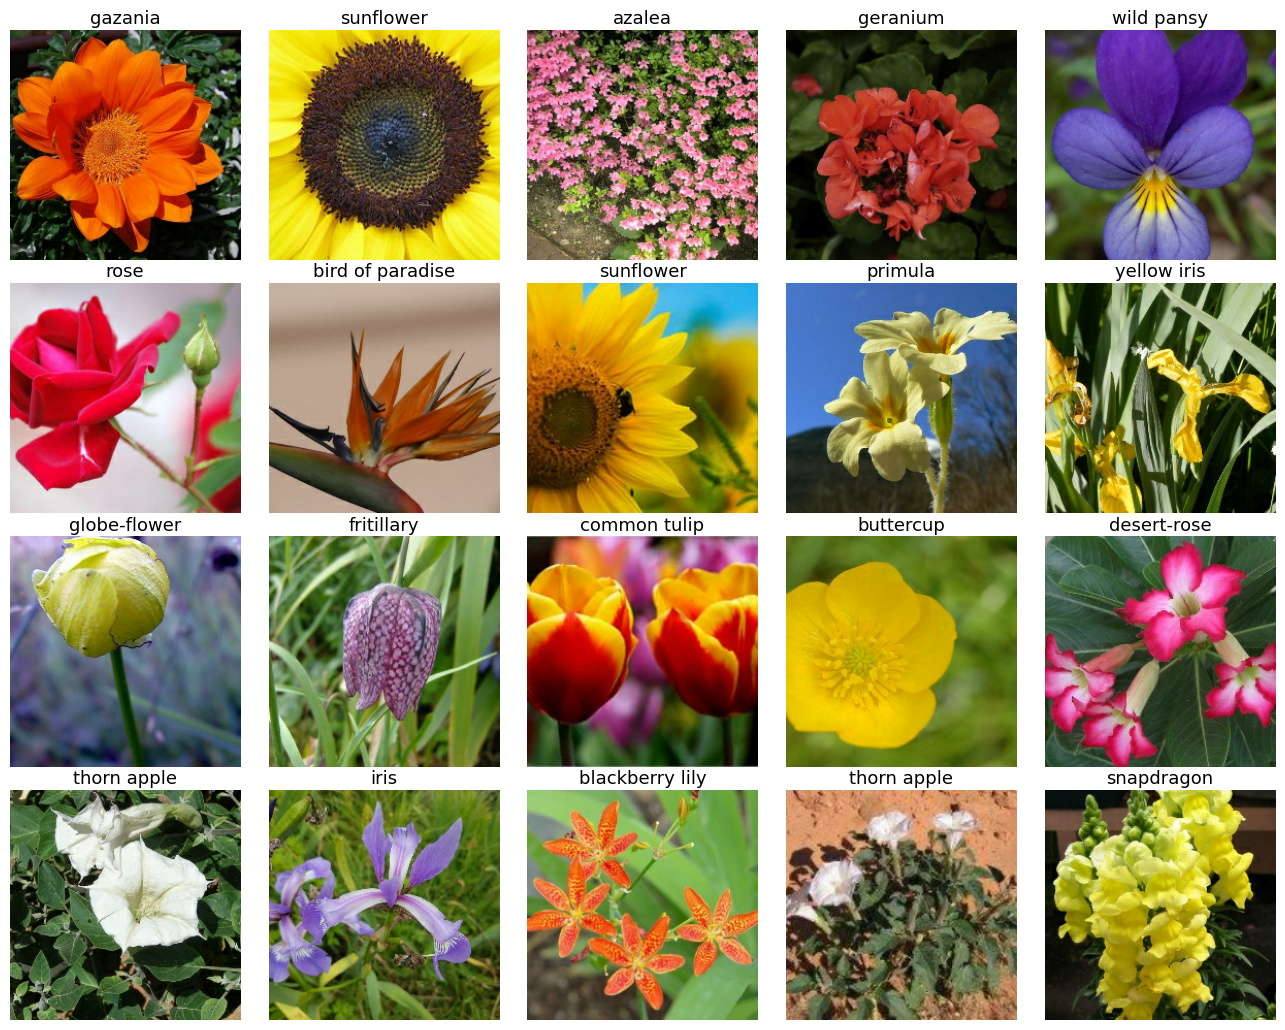

In [299]:
%matplotlib inline

one_batch = next(ds_iter)
display_batch_of_images(one_batch)

In [300]:
class_counts = {}

# Get the total number of iterations
total_iterations = data_load.NUM_TRAINING_IMAGES

# Use tqdm to create a progress bar
for _, label in tqdm(ds_explore.unbatch(), total=total_iterations, desc='Processing images'):
    i = label.numpy()
    if i not in class_counts:
        # print(data_load.CLASSES[i])
        class_counts[i] = 1
    else:
        class_counts[i] += 1
        
    total_iterations -= 1  # Decrement the total_iterations count

    if total_iterations == 0:
        break  # Exit the loop when all elements have been processed

Processing images: 100%|█████████▉| 12752/12753 [00:03<00:00, 4229.25it/s]


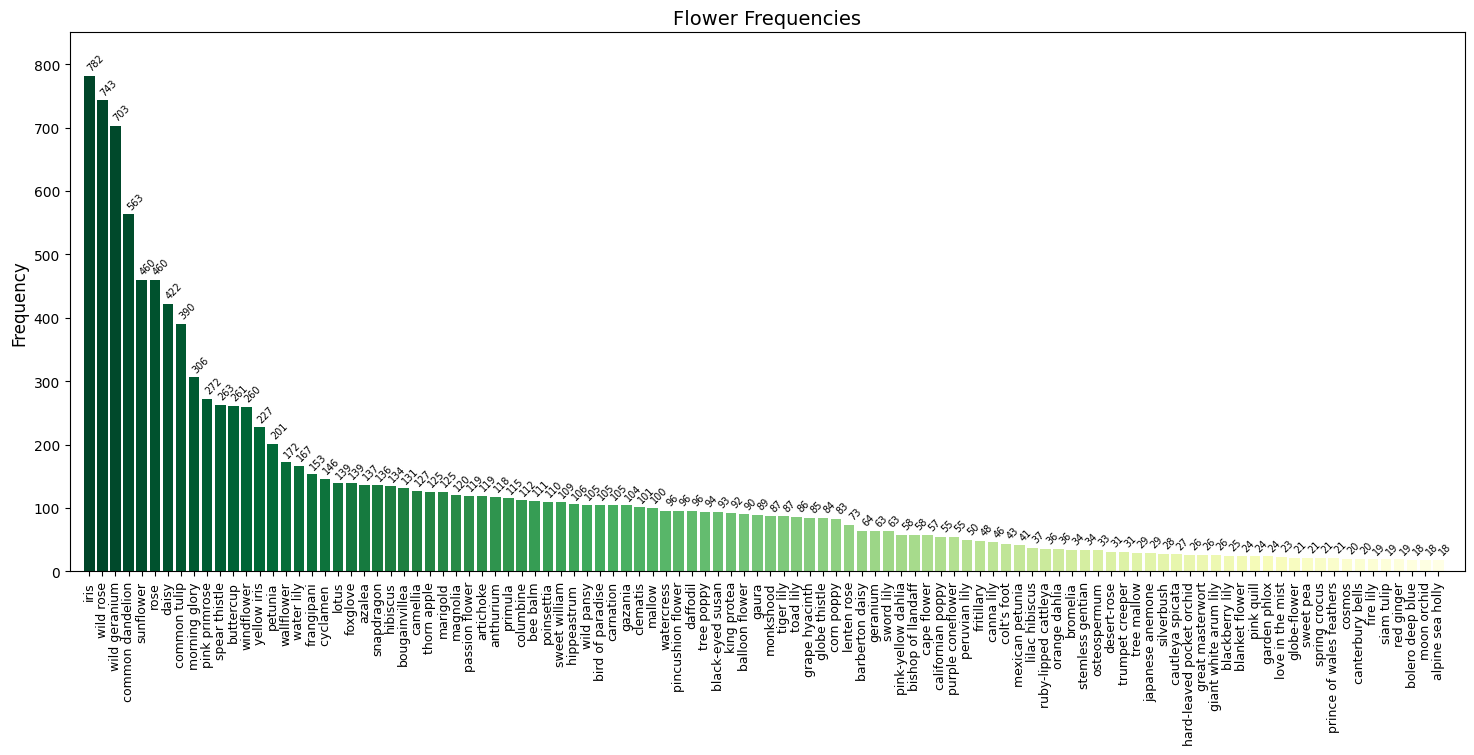

In [301]:
# Sort the data by values in descending order
sorted_data = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the flower names and corresponding frequencies
flowers = [data_load.CLASSES[item[0]] for item in sorted_data]
frequencies = [item[1] for item in sorted_data]

colors = plt.cm.YlGn_r(np.linspace(0, 1, len(flowers)))

# Create the bar plot
plt.figure(figsize=(18, 7))
bars = plt.bar(flowers, frequencies, color=colors)

# Add counts to the top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 + 0.5, height + 5, str(height), ha='center', va='bottom', fontsize=7, rotation = 45)

# Customize the plot
plt.xticks(rotation=90,fontsize=9)
#plt.xlabel('Flower', fontsize = 12)
plt.xlim(-1.5,105)
plt.ylim(0,850)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Flower Frequencies', fontsize = 14)

# Display the plot
plt.show()

In [302]:
# Sort the data by values in descending order
sorted_data = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the flower names and corresponding frequencies
flowers = [data_load.CLASSES[item[0]] for item in sorted_data]
frequencies = [item[1] for item in sorted_data]

# Normalize the frequencies between 0 and 1
normalized_freq = (frequencies - np.min(frequencies)) / (np.max(frequencies) - np.min(frequencies))

color_palette = [
    '#e5f5e0', '#d6efc9', '#c7e9b4', '#b8e39f', '#a9dd8a',
    '#9ad775', '#8bce60', '#7cc94b', '#6db336', '#5ead21',
    '#4fa40c', '#409d0a', '#319608', '#238906', '#147f04',
    '#057802', '#006d01', '#005f01', '#005101', '#004301'
]

# Create a continuous green color mapper
color_mapper = linear_cmap(field_name='frequencies', palette=color_palette, low=np.min(frequencies), high=np.max(frequencies))

# Create a ColumnDataSource to store the data
source = ColumnDataSource(data=dict(flowers=flowers, frequencies=frequencies))

# Create the figure
p = figure(x_range=flowers, height=600, width=900, toolbar_location=None, tools="hover", tooltips=[("Flower", "@flowers"), ("Frequency", "@frequencies")])

# Create the bars
p.vbar(x='flowers', top='frequencies', width=0.9, source=source, line_color='white', fill_color=color_mapper, fill_alpha=0.8)

# Customize the plot
p.xaxis.major_label_orientation = "vertical"
p.y_range.start = 0
# p.xaxis.axis_label = "Flower"
p.yaxis.axis_label = "Frequency"
p.title.text = "Flower Frequencies"
p.title.align = "center"

# Set axis and title text properties
# p.xaxis.axis_label_text_font_size = "12pt"
p.xaxis.major_label_orientation = 45
p.yaxis.axis_label_text_font_size = "11pt"
p.title.text_font_size = "14pt"
p.xgrid.grid_line_color = None

# Set hover tool properties
hover = p.select(dict(type=HoverTool))
hover.mode = 'vline'
hover.line_policy = 'nearest'
hover.point_policy = 'snap_to_data'
hover.tooltips = [("Flower", "@flowers"), ("Frequency", "@frequencies")]

# Show the plot
output_notebook()
show(p)

# Specify the output file name
#filename = "flower_frequencies.html"

# Save the plot
#save(p, filename=filename)

Loading BokehJS ...

## Model to implement

The data will load to data_load based on chosen `IMAGE_SIZE` and `BATCH_SIZE`. Then the model has to be compiled within `strategy.scope()`, compiled with chosen `optimizer`, `loss`, and `metrics`.

### Augmentations

In [303]:
# Specify the maximum amount of cropping and rotation (sampled randomly)
max_crop = 0.6
max_rotate = 20
AUTO = tf.data.experimental.AUTOTUNE
        
# Function sampling random degrees for image rotation
def rand_degree():
    lower = -max_rotate * (np.pi/180.0) # degrees -> radian
    upper =  max_rotate * (np.pi/180.0) 
    return np.random.uniform(lower, upper), max_rotate

# Our manual augmentation function
def manual_augment(image, label):
    #data augmentation to prevent overfitting and to find more patterns.

    # Image dimensions
    height, width = image.shape[-3:-1]

    # Crop image
    crop = np.random.uniform(max_crop,1) # Sample crop size
    box_top  = int(np.random.uniform(0,(1-crop)*height)) # Sample crop location
    box_left = int(np.random.uniform(0,(1-crop)*width))

    cropped = tf.image.crop_to_bounding_box(image, box_top, box_left, int(height*crop), int(width*crop)) # Crop image
    image = tf.image.resize(cropped, (height, width), method='bilinear') # Resize to original image size

    # Alter image
    image = tf.image.random_flip_left_right(image)  # Flipping left-right makes sense due to flower variation
    image = tf.image.random_saturation(image, 0, 3) # Random saturation makes sense due to growth cycles, lighting

    # Rotate image
    degree, max_rotate = rand_degree() # Sample angle

    if np.abs(degree) > (max_rotate/6) * (np.pi/180.0): # If angle is big enough, rotate
        image = tfa.image.rotate(image, degree, fill_mode='nearest')  # Rotation makes sense due to flower variation, foto angle


    #image = tf.image.random_flip_up_down(image)    # Flipping up-down does not make sense because flowers don't grow that way
    #image = tf.image.random_brightness(image, 0.1) 

    return image, label

def cutmixup(batch_inputs: tf.data.Dataset, onehot=True):

    CutMixUp = augment.MixupAndCutmix(
        mixup_alpha = 0.8,
        cutmix_alpha = 0.5, # default 1.0
        prob = 0.6, # default 1.0
        switch_prob = 0.5,
        label_smoothing = 0.1,
        num_classes = 104
    )
    cutmix_images, cutmix_labels = CutMixUp(images=batch_inputs[0], labels=batch_inputs[1])
    if not onehot:
        cutmix_labels = tf.argmax(cutmix_labels, axis=-1)
    
    return cutmix_images, cutmix_labels

def mixup(batch_inputs: tf.data.Dataset, onehot=True):

    CutMixUp = augment.MixupAndCutmix(
        mixup_alpha = 0.8,
        cutmix_alpha = 0.0, # disable CutMix
        prob = 0.6, # default 1.0
        switch_prob = 0.0, # disable CutMix
        label_smoothing = 0.1,
        num_classes = 104
    )
    cutmix_images, cutmix_labels = CutMixUp(images=batch_inputs[0], labels=batch_inputs[1])
    if not onehot:
        cutmix_labels = tf.argmax(cutmix_labels, axis=-1)
    
    return cutmix_images, cutmix_labels

def cutmix(batch_inputs: tf.data.Dataset, onehot=True):

    CutMixUp = augment.MixupAndCutmix(
        mixup_alpha = 0.0, # disable MixUp
        cutmix_alpha = 0.5, # default 1.0
        prob = 0.6, # default 1.0
        switch_prob = 0.5,
        label_smoothing = 0.1,
        num_classes = 104
    )
    cutmix_images, cutmix_labels = CutMixUp(images=batch_inputs[0], labels=batch_inputs[1])
    if not onehot:
        cutmix_labels = tf.argmax(cutmix_labels, axis=-1)
    
    return cutmix_images, cutmix_labels

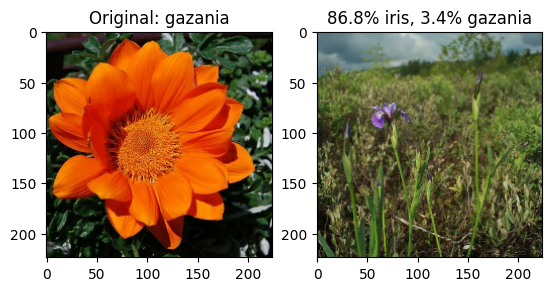

In [304]:
index = 1 # Use the same index for both datasets

ds_train_original = data_load.get_training_dataset(image_augment = False, ordered = True, onehot=False)
ds_train_no_augment = ds_train_original.take(1).cache().repeat()
original_images, orig_labels = next(islice(ds_train_no_augment, index, None))

# Cutmix test

ds_train_aug = data_load.get_training_dataset(batch_augment = cutmixup, ordered = True, onehot = True)
ds_train_augment = ds_train_aug.take(1).cache().repeat()
augmented_images, aug_labels = next(islice(ds_train_augment, index, None))
first_idx, second_idx = tf.math.top_k(aug_labels[0],k=2).indices.numpy()
first_prob, second_prob = tf.math.top_k(aug_labels[0],k=2).values.numpy()

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(original_images[0].numpy())
axes[0].set_title("Original: "+str(data_load.CLASSES[orig_labels[0].numpy()]))

axes[1].imshow(augmented_images[0].numpy())
axes[1].set_title(f'{np.round(first_prob*100,1)}% {data_load.CLASSES[first_idx]}, \
{np.round(second_prob*100,1)}% {data_load.CLASSES[second_idx]}')

plt.show()

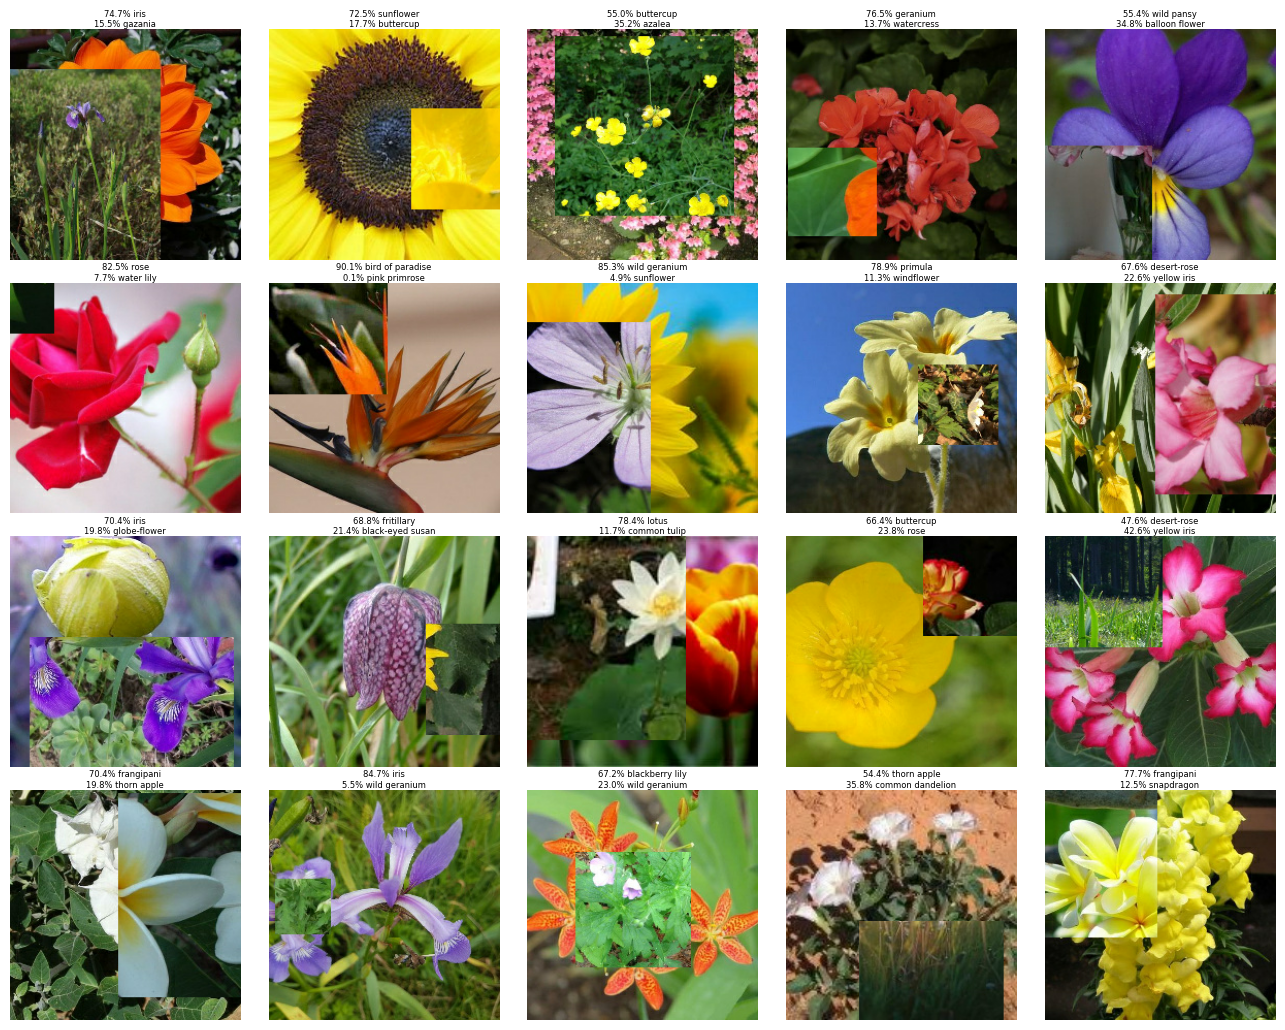

In [305]:
display_batch_of_images(next(iter(ds_train_aug.unbatch().batch(20))))

In [242]:
# assert ds_train_original.element_spec[1].shape == ds_train_aug.element_spec[1].shape
# assert ds_train_original.element_spec[0].shape == ds_train_aug.element_spec[0].shape

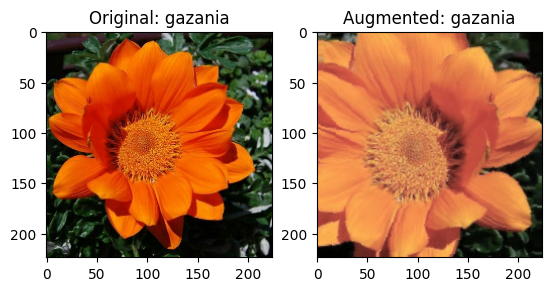

In [308]:
# Manual augmentation test

ds_train_aug = data_load.get_training_dataset(image_augment = manual_augment, ordered = True, onehot=False)
ds_train_augment = ds_train_aug.take(1).cache().repeat()
augmented_images, aug_labels = next(islice(ds_train_augment, index, None))

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(original_images[0].numpy())
axes[0].set_title("Original: "+str(data_load.CLASSES[orig_labels[0].numpy()]))
axes[1].imshow(augmented_images[0].numpy())
axes[1].set_title("Augmented: "+str(data_load.CLASSES[aug_labels[0].numpy()]))
plt.show()

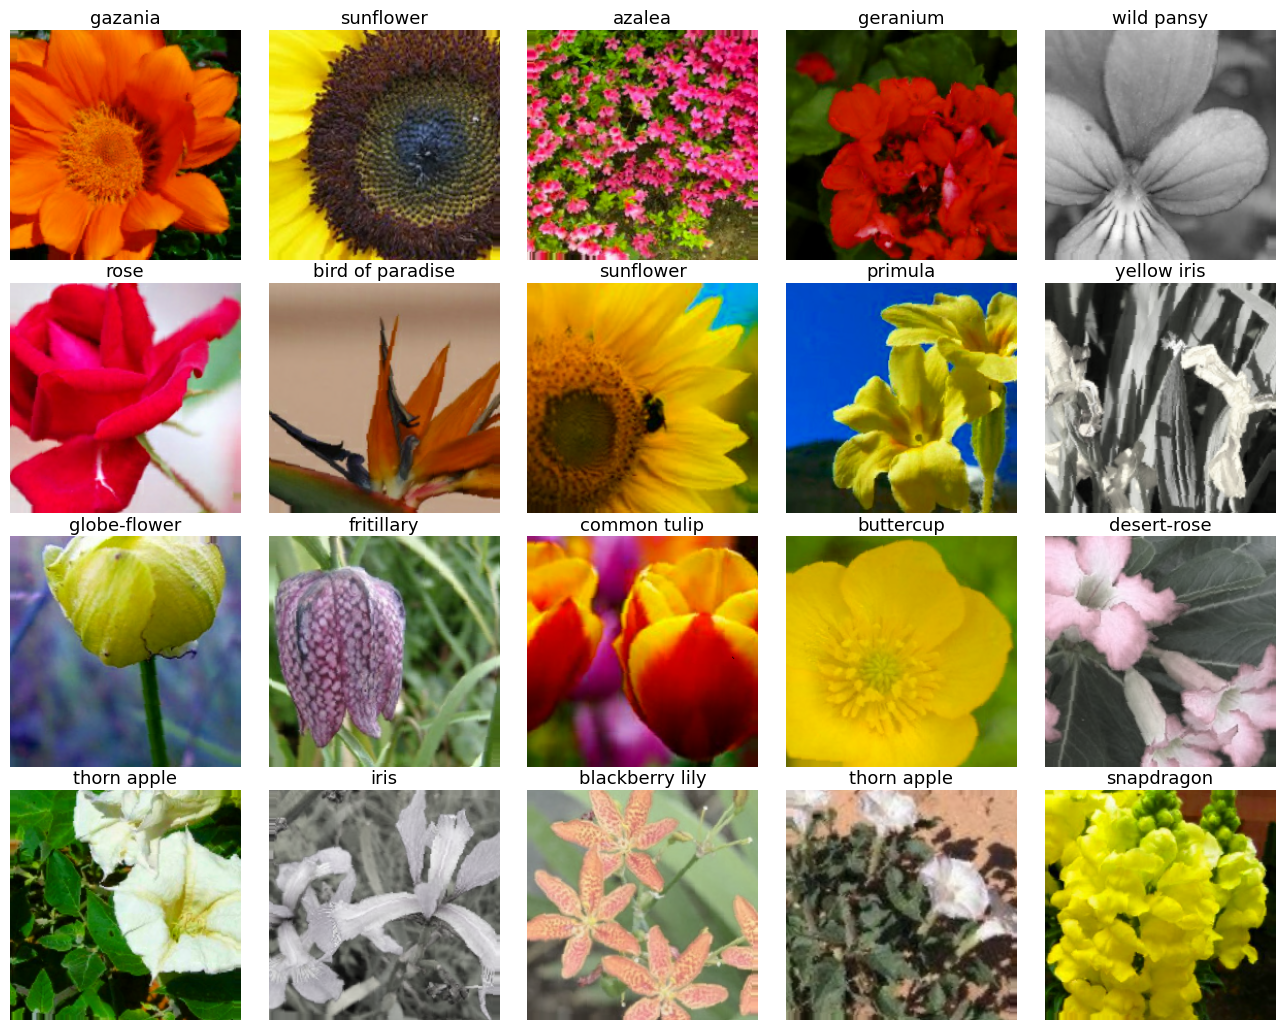

In [309]:
display_batch_of_images(next(iter(ds_train_aug.unbatch().batch(20))))

### Learning rate

Learning rate schedule: start = 1e-05; peak = 5e-05; end = 1.02e-05


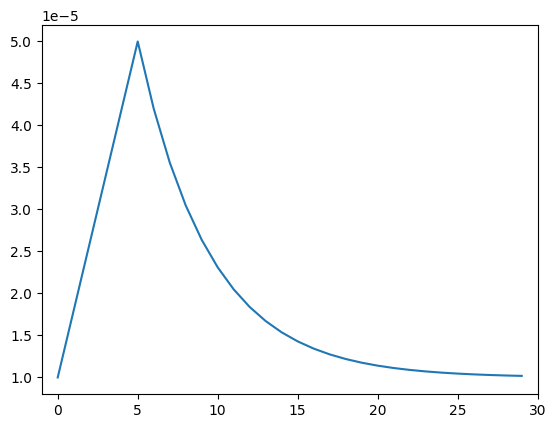

In [310]:
EPOCHS = 30

# define a fine-tuned schedule for the Learning Rate Scheduler 
def exponential_lr(epoch,
                  start_lr=0.00001,min_lr=0.00001,max_lr=0.00005,
                  rampup_epochs = 5, sustain_epochs = 0,
                  exp_decay = 0.8):  # original exp_decay = 0.8
    def lr(epoch, start_lr, min_lr,max_lr,rampup_epochs,sustain_epochs,
          exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr= ((max_lr-start_lr)/
                rampup_epochs * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr 
        else:
            lr = ((max_lr - min_lr)* exp_decay ** (epoch-rampup_epochs-sustain_epochs)
                  + min_lr)
            
        return lr
    return lr(epoch,start_lr,min_lr,max_lr,rampup_epochs,sustain_epochs,exp_decay)

# set learning rate scheduler for callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule=exponential_lr,verbose=True)

# learning rate chart
epoch_rng = [i for i in range(EPOCHS)] 
y = [exponential_lr(x) for x in epoch_rng]
plt.plot(epoch_rng,y)
plt.xlim(-1, EPOCHS)

print("Learning rate schedule: start = {:.3g}; peak = {:.3g}; end = {:.3g}".format(y[0], max(y), y[-1]))

### Weighting the classes

In [311]:
def get_weight_for_class(class_id):
    counting = class_counts[class_id]
    weight = 1 / counting
    return weight

#This is the dictionary to use in model fitting to further tweak it
weight_per_class = {class_id: get_weight_for_class(class_id) for class_id in class_counts.keys()}

#In order to use it, add 
#class_weight = weight_per_class 
#inside the fit function

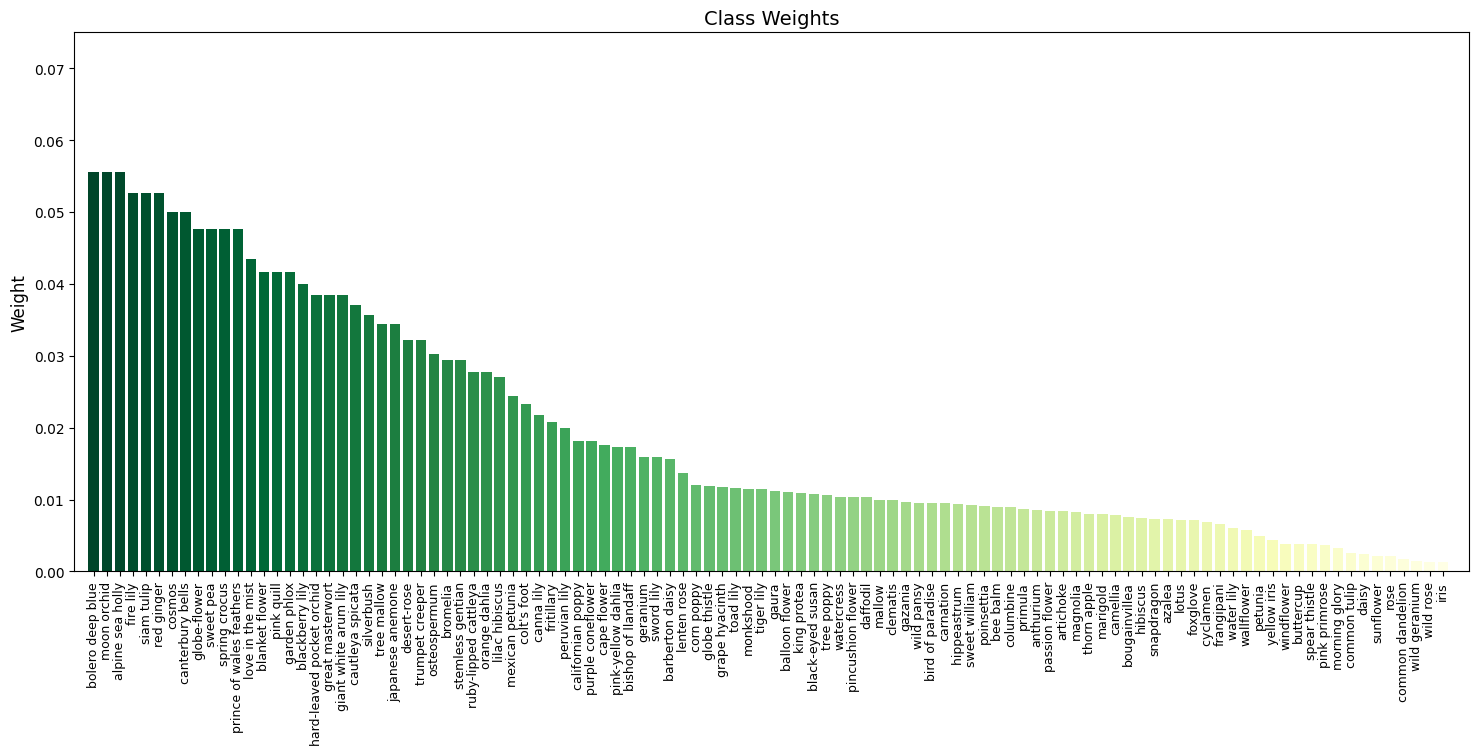

In [312]:
# Sort the data by values in descending order
sorted_weights = sorted(weight_per_class.items(), key=lambda x: x[1], reverse=True)

# Extract the flower names and corresponding frequencies
flowers = [data_load.CLASSES[item[0]] for item in sorted_weights]
weights = [item[1] for item in sorted_weights]

colors = plt.cm.YlGn_r(np.linspace(0, 1, len(flowers)))

# Create the bar plot
plt.figure(figsize=(18, 7))
bars = plt.bar(flowers, weights, color=colors)


# Customize the plot
plt.xticks(rotation=90,fontsize=9)
#plt.xlabel('Flower', fontsize = 12)
plt.xlim(-1.5,105)
plt.ylim(0,0.075)
plt.ylabel('Weight', fontsize = 12)
plt.title('Class Weights', fontsize = 14)

# Display the plot
plt.show()

### Model compiling

In [ ]:
"""
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten

gu_seed = tf.keras.initializers.GlorotUniform(seed=1)

with strategy.scope():
    pretrained_model = tf.keras.applications.vgg16.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=[*IMAGE_SIZE, 3],
        classes=len(data_load.CLASSES),
        classifier_activation='softmax'
    )
    pretrained_model.trainable = False
    
    for layer in pretrained_model.layers[15:]:
        layer.trainable = True
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(2048, activation="relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation="relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(len(data_load.CLASSES), activation='softmax')
    ])
"""

In [313]:
with strategy.scope():
#     pretrained_model = tf.keras.applications.InceptionResNetV2(
#     weights = 'imagenet', 
#     include_top = False, 
#     input_shape = [*IMAGE_SIZE, 3])

#     pretrained_model = tf.keras.applications.MobileNetV2(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
#     pretrained_model = tf.keras.applications.ResNet152V2(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
#     pretrained_model = tf.keras.applications.InceptionV3(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
    pretrained_model = efficientnet.EfficientNetB7(
         weights = 'noisy-student', 
         include_top = False, 
         input_shape = [*IMAGE_SIZE, 3])
    
#   pretrained_model = tf.keras.applications.DenseNet201(
#       weights = 'imagenet', 
#       include_top = False, 
#       input_shape = [*IMAGE_SIZE, 3])
        
#     pretrained_model = tf.keras.applications.xception.Xception(
#         weights='imagenet',
#         include_top=False ,
#         input_shape=[*IMAGE_SIZE, 3]
#     )

#     pretrained_model = tf.keras.applications.nasnet.NASNetLarge(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])

#     pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])

#     pretrained_model = tf.keras.applications.vgg16.VGG16(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])



    pretrained_model.trainable = True
    
    model = tf.keras.Sequential([        
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(data_load.CLASSES), activation='softmax')
    ])

In [332]:
ds_train = data_load.get_training_dataset(image_augment=manual_augment, onehot=False)
ds_valid = data_load.get_validation_dataset(onehot=False)
ds_test  = data_load.get_test_dataset(ordered=True)

In [333]:
loss_measure = '' if len(next(iter(ds_valid))[1].shape)==2 else 'sparse_'
# sparse measures used when onehot is not applied to save resources

model.compile(
    optimizer='adam',
    loss = f'{loss_measure}categorical_crossentropy',
    metrics=[f'{loss_measure}categorical_accuracy'],
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model_name = 'man_aug_efficientNetB7'

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functional  (None, 7, 7, 2560)       64097680  
 )                                                               
                                                                 
 global_average_pooling2d_3   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 104)               266344    
                                                                 
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


## Training

In [334]:
EPOCHS = 2
STEPS_PER_EPOCH = data_load.TRAINING_STEPS_PER_EPOCH

history_manual = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback, early_stopping],
    # callbacks=[early_stopping]
    class_weight = weight_per_class #tuning11
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/3


2023-06-12 16:59:43.523052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-12 16:59:47.184334: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - ETA: 0s - loss: 0.0079 - sparse_categorical_accuracy: 0.6634

2023-06-12 17:03:35.925375: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-12 17:03:36.672818: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - 376s 718ms/step - loss: 0.0079 - sparse_categorical_accuracy: 0.6634 - val_loss: 1.3662 - val_sparse_categorical_accuracy: 0.6786 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/3
99/99 [==============================] - 33s 336ms/step - loss: 0.0055 - sparse_categorical_accuracy: 0.7311 - val_loss: 0.8384 - val_sparse_categorical_accuracy: 0.7883 - lr: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/3
99/99 [==============================] - 33s 334ms/step - loss: 0.0035 - sparse_categorical_accuracy: 0.8082 - val_loss: 0.5704 - val_sparse_categorical_accuracy: 0.8559 - lr: 5.0600e-04


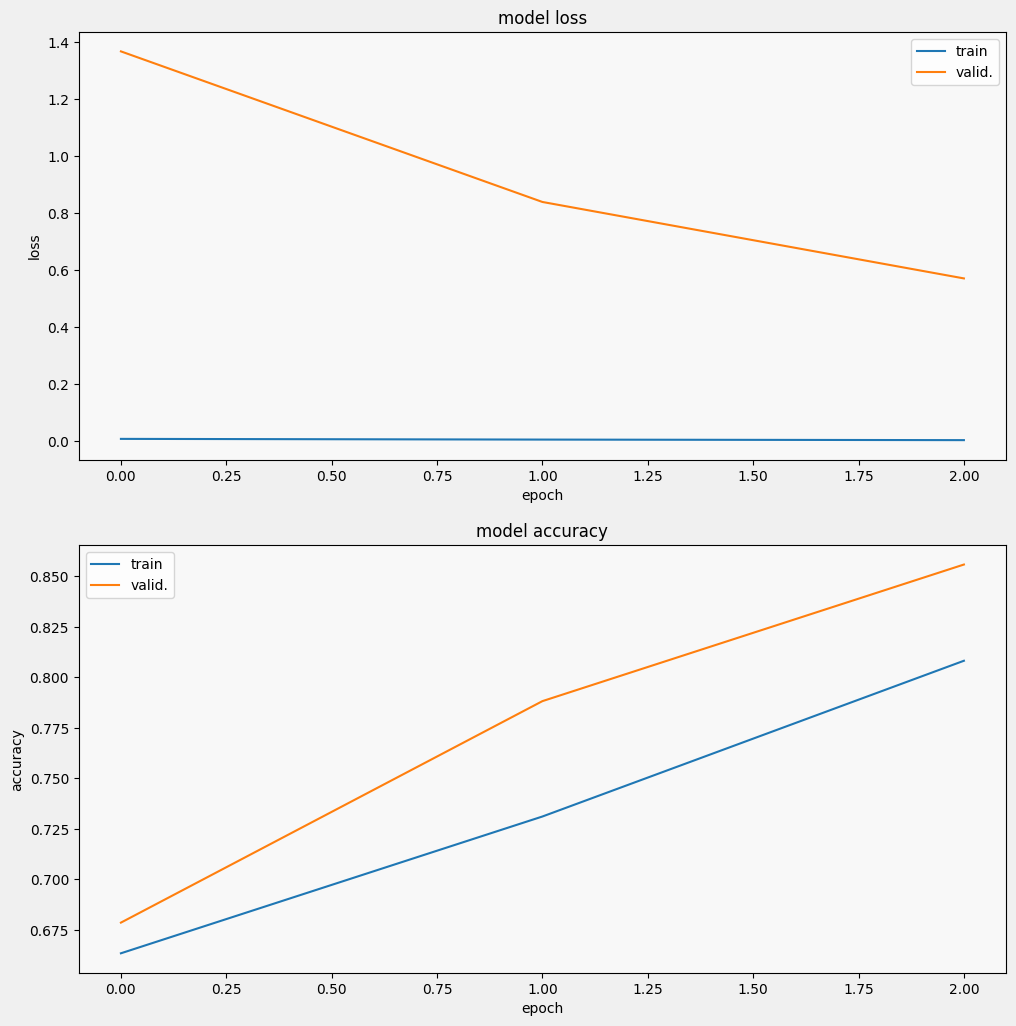

In [339]:
display_training_curves(
    history_manual.history['loss'],
    history_manual.history['val_loss'],
    'loss',
    211
)
display_training_curves(
    history_manual.history[f'{loss_measure}categorical_accuracy'],
    history_manual.history[f'val_{loss_measure}categorical_accuracy'],
    'accuracy',
    212
)

In [340]:
EPOCHS = 2
STEPS_PER_EPOCH = data_load.TRAINING_STEPS_PER_EPOCH

loss_measure = ''

model.compile(
    optimizer='adam',
    loss = f'{loss_measure}categorical_crossentropy',
    metrics=[f'{loss_measure}categorical_accuracy'],
)

history_cutmixup = model.fit(
    data_load.get_training_dataset(batch_augment=cutmixup, onehot=True),
    validation_data=data_load.get_validation_dataset(onehot=True),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback, early_stopping],
    # callbacks=[early_stopping]
    class_weight = weight_per_class #tuning11
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/2


2023-06-12 17:09:02.518182: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-12 17:09:06.200273: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - ETA: 0s - loss: 0.0179 - categorical_accuracy: 0.6816

2023-06-12 17:09:52.188942: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-12 17:09:52.936537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - 170s 467ms/step - loss: 0.0179 - categorical_accuracy: 0.6816 - val_loss: 0.7951 - val_categorical_accuracy: 0.7977 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/2
99/99 [==============================] - 33s 333ms/step - loss: 0.0168 - categorical_accuracy: 0.7121 - val_loss: 0.7068 - val_categorical_accuracy: 0.8389 - lr: 8.1000e-04


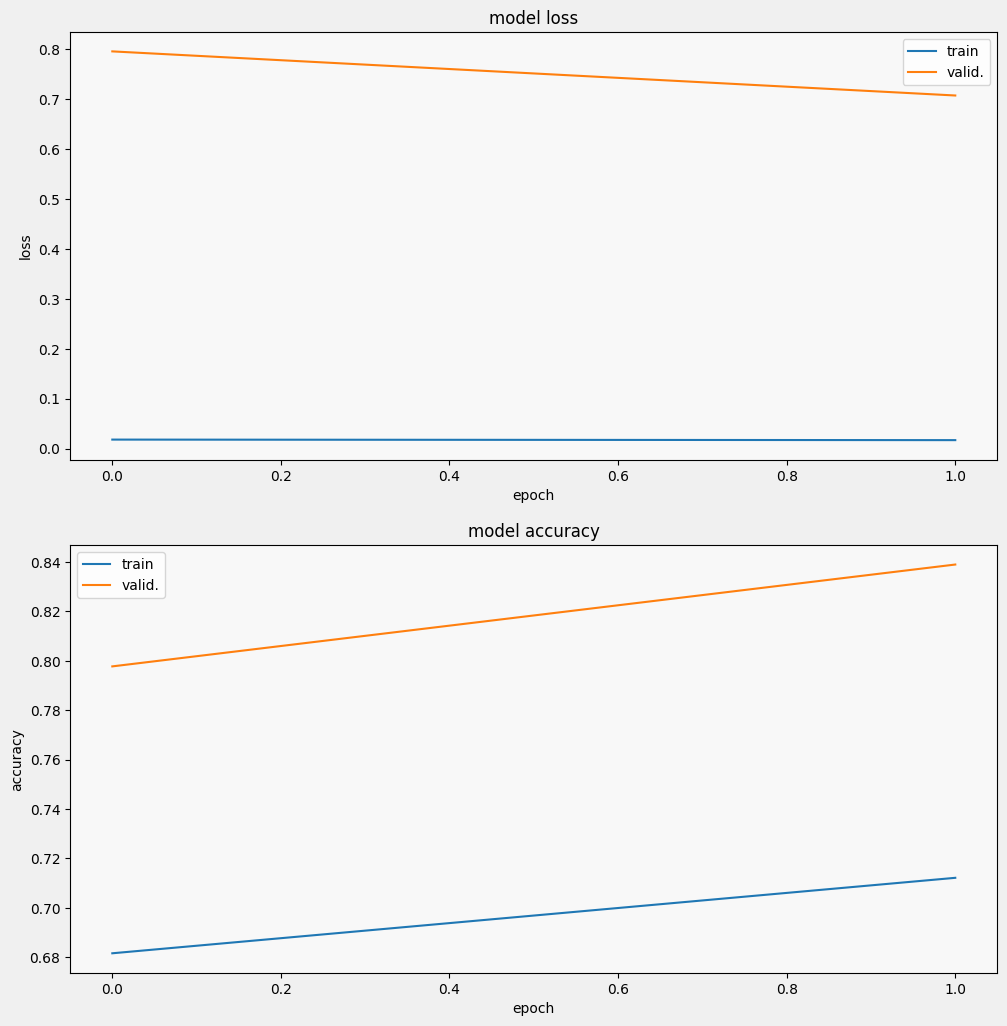

In [341]:
display_training_curves(
    history_cutmixup.history['loss'],
    history_cutmixup.history['val_loss'],
    'loss',
    211
)
display_training_curves(
    history_cutmixup.history[f'{loss_measure}categorical_accuracy'],
    history_cutmixup.history[f'val_{loss_measure}categorical_accuracy'],
    'accuracy',
    212
)

In [ ]:
"""
np.save(f'history_{model_name}.npy',history.history)
model.save(f'model_{model_name}.h5')
"""

## Testing 10 different models

In [ ]:
"""
image_size = 224
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

IMAGE_SIZE = [image_size, image_size]

data_load = DataLoad(image_size=image_size, batch_size=BATCH_SIZE)

ds_train = data_load.get_training_dataset(image_augment=False)
ds_valid = data_load.get_validation_dataset()
ds_test = data_load.get_test_dataset()

EPOCHS = 30
STEPS_PER_EPOCH = data_load.TRAINING_STEPS_PER_EPOCH
"""

In [ ]:
"""
from tensorflow.keras import layers, callbacks

import efficientnet.tfkeras as efficientnet


with strategy.scope():
    inception_resnet_v2 = tf.keras.applications.InceptionResNetV2(
             weights = 'imagenet', 
             include_top = False, 
             input_shape = [*IMAGE_SIZE, 3])

    inception_v3 = tf.keras.applications.InceptionV3(
             weights = 'imagenet', 
             include_top = False, 
             input_shape = [*IMAGE_SIZE, 3])

    mobilenet_v2 = tf.keras.applications.MobileNetV2(
             weights = 'imagenet', 
             include_top = False, 
             input_shape = [*IMAGE_SIZE, 3])

    resnet_152_v2 = tf.keras.applications.ResNet152V2(
             weights = 'imagenet', 
             include_top = False, 
             input_shape = [*IMAGE_SIZE, 3])

    efficientnet_b7 = efficientnet.EfficientNetB7(
             weights = 'noisy-student', 
             include_top = False, 
             input_shape = [*IMAGE_SIZE, 3])

    efficientnet_v2l = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
             weights = 'imagenet', 
             include_top = False, 
             input_shape = [*IMAGE_SIZE, 3])

    densenet_201 = tf.keras.applications.DenseNet201(
             weights = 'imagenet', 
             include_top = False, 
             input_shape = [*IMAGE_SIZE, 3])

    xception_ = tf.keras.applications.xception.Xception(
             weights='imagenet',
             include_top=False ,
             input_shape=[*IMAGE_SIZE, 3])

    nasnet_large = tf.keras.applications.nasnet.NASNetLarge(
             weights = 'imagenet', 
             include_top = False, 
             input_shape = [*IMAGE_SIZE, 3])

    vgg16_ = tf.keras.applications.vgg16.VGG16(
             weights = 'imagenet', 
             include_top = False, 
             input_shape = [*IMAGE_SIZE, 3])


    models = [inception_resnet_v2,inception_v3,mobilenet_v2,resnet_152_v2,efficientnet_b7,efficientnet_v2l,densenet_201,xception_,nasnet_large,vgg16_]

    model_names = ['InceptionResNetV2','InceptionV3','MobileNetV2','ResNet152V2','EfficientNetB7','EfficientNetV2L','DenseNet201','Xception','NASNetLarge','VGG16']
    
    """

In [ ]:
"""
# Directory to save the models
save_dir = 'saved_models_before'

# Create the save directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
"""

In [ ]:
"""
# Loop over the models
for i in range(len(models)):
    with strategy.scope():
    
        pretrained_model = models[i]
        model_name = model_names[i]
        
        # Set the pretrained model as trainable
        pretrained_model.trainable = True
        
        # Create a new model
        model = tf.keras.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(data_load.CLASSES), activation='softmax')
        ])
        
        # Compile the model
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

        # Print model summary
        model.summary()

        # Save the model
        model_path = os.path.join(save_dir, f'{model_name}.h5')
        model.save(model_path)
        print(f'Saved model {model_name} at {model_path}')
"""

In [ ]:
"""
# Directory to save the models
save_dir = 'saved_models_after'

# Create the save directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
"""

In [ ]:
""""
early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,
            patience=5,
            restore_best_weights=True
        )
"""

In [ ]:
"""

# Define the paths for loading and saving models
load_dir = 'saved_models_before'  # Path to the folder containing the saved models
save_dir = 'saved_models_after'  # Path to the folder to save the trained models

# List the files in the load directory
model_files = os.listdir(load_dir)

# Dictionary to store model results
model_results = {}

cmdataset = data_load.get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(data_load.NUM_VALIDATION_IMAGES))).numpy()
labels = range(len(data_load.CLASSES))
    
# Loop through the model files
for model_file in model_files:
    with strategy.scope():
        # Load the model
        print(model_file + ":")
        model_path = os.path.join(load_dir, model_file)
        model = tf.keras.models.load_model(model_path)

        # Train the model
        history = model.fit(
            ds_train,
            validation_data=ds_valid,
            epochs=EPOCHS,
            steps_per_epoch=STEPS_PER_EPOCH,
            callbacks=[early_stopping])

        # Save the model and training history
        trained_model_name = f'trained_{model_file}'  # You can modify the name if desired
        trained_model_path = os.path.join(save_dir, trained_model_name)
        model.save(trained_model_path)
        print(f'Saved trained model {trained_model_name} at {trained_model_path}')

        history_path = f'history_{model_file}.npy'
        np.save(history_path, history.history)
        print(f'Saved training history at {history_path}')
    
    # Evaluate the model
    cm_probabilities = model.predict(images_ds)
    cm_predictions = np.argmax(cm_probabilities, axis=-1)

    score = f1_score(
        cm_correct_labels,
        cm_predictions,
        labels=labels,
        average='macro')

    precision = precision_score(
        cm_correct_labels,
        cm_predictions,
        labels=labels,
        average='macro')

    recall = recall_score(
        cm_correct_labels,
        cm_predictions,
        labels=labels,
        average='macro')

    model_results[model_file] = [score, precision, recall]

"""

In [ ]:
"""

results = pd.DataFrame.from_dict(model_results, orient='index', columns=['f1', 'precision', 'recall'])
results.index.name = 'Model'

results = results.sort_values(by='f1', ascending=False)

results.index = results.index.str.replace('.h5', '')

print(results)

"""

In [ ]:
"""
# Set color scheme for the bars
colors = ['tab:red', 'tab:blue', 'tab:green']
other_color = 'lightgray'

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set color for the first three columns and gray for the rest
bar_colors = [colors[i] if i < 3 else other_color for i in range(len(results))]

results['f1'].plot(kind='bar', ax=ax, color=bar_colors)

# Add labels to the bars
for i, value in enumerate(results['f1']):
    ax.text(i, value, f'{value:.3f}', ha='center', va='bottom', color='black')

# Set the tick labels
ax.set_xticklabels(results.index, rotation=45)

# Set axis labels and title
ax.set_xlabel('')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores')

# Display the plot
plt.tight_layout()
plt.show()
"""

In [ ]:
"""
results.to_csv('results.csv')

"""

## Augmentation training

In [342]:
with strategy.scope():

    efficientnet_b7 = efficientnet.EfficientNetB7(
             weights = 'noisy-student', 
             include_top = False,
             input_shape = [*IMAGE_SIZE, 3])

    densenet_201 = tf.keras.applications.DenseNet201(
             weights = 'imagenet', 
             include_top = False,
             input_shape = [*IMAGE_SIZE, 3])

    xception_ = tf.keras.applications.xception.Xception(
             weights = 'imagenet',
             include_top = False ,
             input_shape = [*IMAGE_SIZE, 3])

    models = [efficientnet_b7,densenet_201,xception_]

    model_names = ['EfficientNetB7','DenseNet201','Xception']

83683744/83683744 [==============================] - 1s 0us/step


In [343]:
# Directory to save the models
load_dir = 'saved_models_before'
save_dir = 'saved_models_after'
history_dir = 'histories'

# Create the save directory if it doesn't exist
if not os.path.exists(load_dir):
    os.makedirs(load_dir)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(history_dir):
    os.makedirs(history_dir)

In [344]:
# Loop over the models
for i in range(len(models)):
    with strategy.scope():
    
        pretrained_model = models[i]
        model_name = model_names[i]
        
        # Set the pretrained model as trainable
        pretrained_model.trainable = True
        
        # Create a new model
        test_model = tf.keras.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(data_load.CLASSES), activation='softmax')
        ])
        
        # Compile the model
        test_model.compile(
            optimizer='adam',
            loss='categorical_crossentropy', # previously sparse_categorical_accuracy, but this does not work with batch augment
            metrics=['categorical_accuracy'] # previously sparse_categorical_accuracy, but this does not work with batch augment
        )

        # Print model summary
        test_model.summary()

        # Save the model
        model_path = os.path.join(load_dir, f'{model_name}.h5')
        test_model.save(model_path)
        print(f'Saved model {model_name} at {model_path}')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functional  (None, 7, 7, 2560)       64097680  
 )                                                               
                                                                 
 global_average_pooling2d_4   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 104)               266344    
                                                                 
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________
Saved model EfficientNetB7 at saved_models_before/EfficientNetB7.h5
Model: "sequential_5"
_________________________________________________________________
 Layer (type

In [345]:
image_size = 224
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [image_size, image_size]

data_load = DataLoad(image_size=image_size, batch_size=BATCH_SIZE)

ds_valid = data_load.get_validation_dataset(onehot=True)
ds_test = data_load.get_test_dataset(ordered=True)

EPOCHS = 10
STEPS_PER_EPOCH = data_load.TRAINING_STEPS_PER_EPOCH

cmdataset = data_load.get_validation_dataset(ordered=True, onehot=False)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(data_load.NUM_VALIDATION_IMAGES))).numpy()
labels = range(len(data_load.CLASSES))

# Define the paths for loading and saving models
load_dir = 'saved_models_before'  # Path to the folder containing the saved models
save_dir = 'saved_models_after'  # Path to the folder to save the trained models
history_dir = 'histories'

In [346]:
def train_val_loop(model_file, augmentation):
    
    if not augmentation:
        aug_name = 'no_aug'
        ds_train = data_load.get_training_dataset(onehot=True)
    elif type(augmentation) == list:
        aug_name = 'combination'
        ds_train = data_load.get_training_dataset(image_augmentation=augmentation[0],
                                                  batch_augment=augmentation[1],
                                                  onehot=True)
    else:
        aug_name = augmentation.__name__
        if augmentation == manual_augment:
            ds_train = data_load.get_training_dataset(image_augment=augmentation, onehot=True)
        elif len(augmentation.__annotations__) == 1:
            ds_train = data_load.get_training_dataset(batch_augment=augmentation, onehot=True)  
    
    with strategy.scope():
        
        # Load the model
        print(f'{model_file} + {aug_name}:')
        model_path = os.path.join(load_dir, model_file)
        test_model = tf.keras.models.load_model(model_path)

        history = test_model.fit(
            ds_train,
            validation_data=ds_valid,
            epochs=EPOCHS,
            steps_per_epoch=STEPS_PER_EPOCH,
            callbacks=[lr_callback, early_stopping],
            class_weight = weight_per_class
        )

    # Save the model and training history
    trained_model_name = f'{aug_name}_{model_file}'  # You can modify the name if desired
    trained_model_path = os.path.join(save_dir, trained_model_name)
    test_model.save(trained_model_path)
    print(f'Saved {trained_model_name} at {trained_model_path}')

    model_name = trained_model_name.replace('.h5','')
    history_path = f'{history_dir}/history_{model_name}.npy'
    np.save(history_path, history.history)
    print(f'Saved history at {history_path}')

    # Evaluate the model
    cm_probabilities = test_model.predict(images_ds)
    cm_predictions = np.argmax(cm_probabilities, axis=-1)

    score = f1_score(
        cm_correct_labels,
        cm_predictions,
        labels=labels,
        average='macro')

    precision = precision_score(
        cm_correct_labels,
        cm_predictions,
        labels=labels,
        average='macro')

    recall = recall_score(
        cm_correct_labels,
        cm_predictions,
        labels=labels,
        average='macro')

    model_results[trained_model_name] = [score, precision, recall]
    
    return score, trained_model_name

In [ ]:
# Dictionary to store model results
model_results = {}
best_f1 = 0
best_f1_model = None

# List the files in the load directory

# model_files = os.listdir(load_dir)
model_files = ['EfficientNetB7.h5'] # Left only one model for comparisons

augmentations = [False, cutmixup, manual_augment, [manual_augment,cutmixup]]

for n, model_file in enumerate(model_files):
    
    for m, augmentation in enumerate(augmentations):
        
        print(f'\nModel {n*len(augmentations)+(m+1)}/{len(model_files)*len(augmentations)}')
        
        test_f1_score, test_model_name = train_val_loop(model_file, augmentation)
        if test_f1_score > best_f1:
            best_f1 = test_f1_score
            best_f1_model = test_model_name


Model 1/4
EfficientNetB7.h5 + no_aug:

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10


2023-06-12 17:16:15.779366: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-12 17:16:19.980204: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


In [ ]:
pd.DataFrame(model_results).T.sort_values(2, ascending=False)

In [ ]:
histories = pd.DataFrame(columns=['model','augment','categorical_accuracy','loss','val_loss','val_categorical_accuracy'])

for filename in os.listdir('/kaggle/working/histories/'):
    
    if filename[:8] == 'history_':
        file_dict = np.load('/kaggle/working/histories/'+filename, allow_pickle=True).item()
        file_history_dict = {}
        for key, values in file_dict.items():
            file_history_dict[key] = values[-1]
        
        clean_filename = filename.lstrip('history_').rstrip('.npy')
        model_name = clean_filename.split('_')[-1]
        augment_name = clean_filename.replace(model_name,'')
        file_history_dict['model'] = model_name
        file_history_dict['augment'] = augment_name.rstrip('_')
        
        histories.loc[len(histories)] = file_history_dict

histories.sort_values('val_sparse_categorical_accuracy', ascending=False)

## Confusion matrix

In [ ]:
model = tf.keras.models.load_model(f'/kaggle/working/saved_models_after/{best_f1_model}')

# Load validation dataset from DataLoad object
cmdataset = data_load.get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

# Get correct labels and model predictions
cm_correct_labels = next(iter(labels_ds.batch(data_load.NUM_VALIDATION_IMAGES))).numpy()

cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

# Compute confusion matrix and normalize
labels = range(len(data_load.CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T


In [ ]:

score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)

display_confusion_matrix(cmat, score, precision, recall)

In [ ]:
"""
#Since the entire matrix is too large to be visualised at once I made an example subset of it

# Define class names
class_names = data_load.CLASSES[:10]

# Get confusion matrix for first 10 classes
cmat_subset = cmat[:10, :10]

# Normalize confusion matrix
#cmat_subset = (cmat_subset.T / cmat_subset.sum(axis=1)).T

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cmat_subset, cmap='YlGn')

# Show all ticks
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))

# Label ticks with class names
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Axis names
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, "{:.2f}".format(cmat_subset[i, j]),
                       ha="center", va="center", color="black")

# Set plot title and colorbar
ax.set_title("Confusion Matrix (Subset)", fontsize=16)
plt.colorbar(im)
plt.show()
"""

In [ ]:
#Since the entire matrix is too large to be visualised at once I made an example subset of it

# Define class names
class_names = data_load.CLASSES[:10]

# Get confusion matrix for first 10 classes
cmat_subset = cmat[:10, :10]

# Normalize confusion matrix
#cmat_subset = (cmat_subset.T / cmat_subset.sum(axis=1)).T

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cmat_subset, cmap='YlGn')

# Show all ticks
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))

# Label ticks with class names
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Axis names
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, "{:.2f}".format(cmat_subset[i, j]),
                       ha="center", va="center", color="black")

# Set plot title and colorbar
ax.set_title("Confusion Matrix (Subset)", fontsize=16)
plt.colorbar(im)
plt.show()

## Visual validation

In [ ]:

dataset = cmdataset.unbatch().batch(20)
batch = iter(dataset)


In [ ]:

images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)


# Predictions to submit

In [ ]:
def gen_submission_csv(model, data_load=DataLoad(), model_name=None, verbose=False):
    if not model_name:
        print('This will generate a final submission.csv file')
        filename = 'submission.csv'
    else:
        filename = f'submission_{model_name}.csv'
    
    print('Computing predictions...')
    ds_test = data_load.get_test_dataset(ordered=True)
    test_images_ds = ds_test.map(lambda image, idnum: image).batch(BATCH_SIZE)
    probabilities = model.predict(test_images_ds, steps=data_load.TEST_STEPS_PER_EPOCH+1)
    predictions = np.argmax(probabilities, axis=-1)
    
    print(f'Generating {filename} file...')
    test_ids_ds = ds_test.map(lambda image, idnum: idnum)
    test_ids = next(iter(test_ids_ds.batch(data_load.NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
    
    np.savetxt(filename, 
               np.rec.fromarrays([test_ids, predictions]), 
               fmt=['%s', '%d'], 
               delimiter=',', 
               header='id,label', 
               comments='')
    if verbose:
        print()
        !head submission_{model_name}.csv

In [ ]:
# If submitting to the competition, model_name should be either ignored or None

gen_submission_csv(model, data_load, model_name=None)

# Submitting

If you haven't already, create your own editable copy of this notebook by clicking on the Copy and Edit button in the top right corner. Then, submit to the competition by following these steps:

1. Begin by clicking on the blue Save Version button in the top right corner of the window. This will generate a pop-up window.
2. Ensure that the Save and Run All option is selected, and then click on the blue Save button.
3. This generates a window in the bottom left corner of the notebook. After it has finished running, click on the number to the right of the Save Version button. This pulls up a list of versions on the right of the screen. Click on the ellipsis (...) to the right of the most recent version, and select Open in Viewer. This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the Output tab on the right of the screen. Then, click on the file you would like to submit, and click on the blue Submit button to submit your results to the leaderboard.

You have now successfully submitted to the competition!